# Jul 21st, 2022 (Fig-2 OCs; combined; n=128)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir (p=20)

In [2]:
nn = 128
perc = 20
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n128-p20/Fig2_OCs

## Prepare (128)

In [3]:
mice = Mice(nn)
num_k = None

## Get results

In [4]:
final_perm={4: 6, 5: 4, 6: 5}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(7)
}
final_perm

{0: 0, 1: 1, 2: 2, 3: 3, 4: 6, 5: 4, 6: 5}

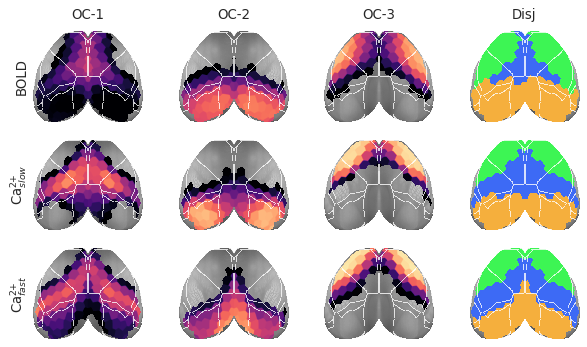

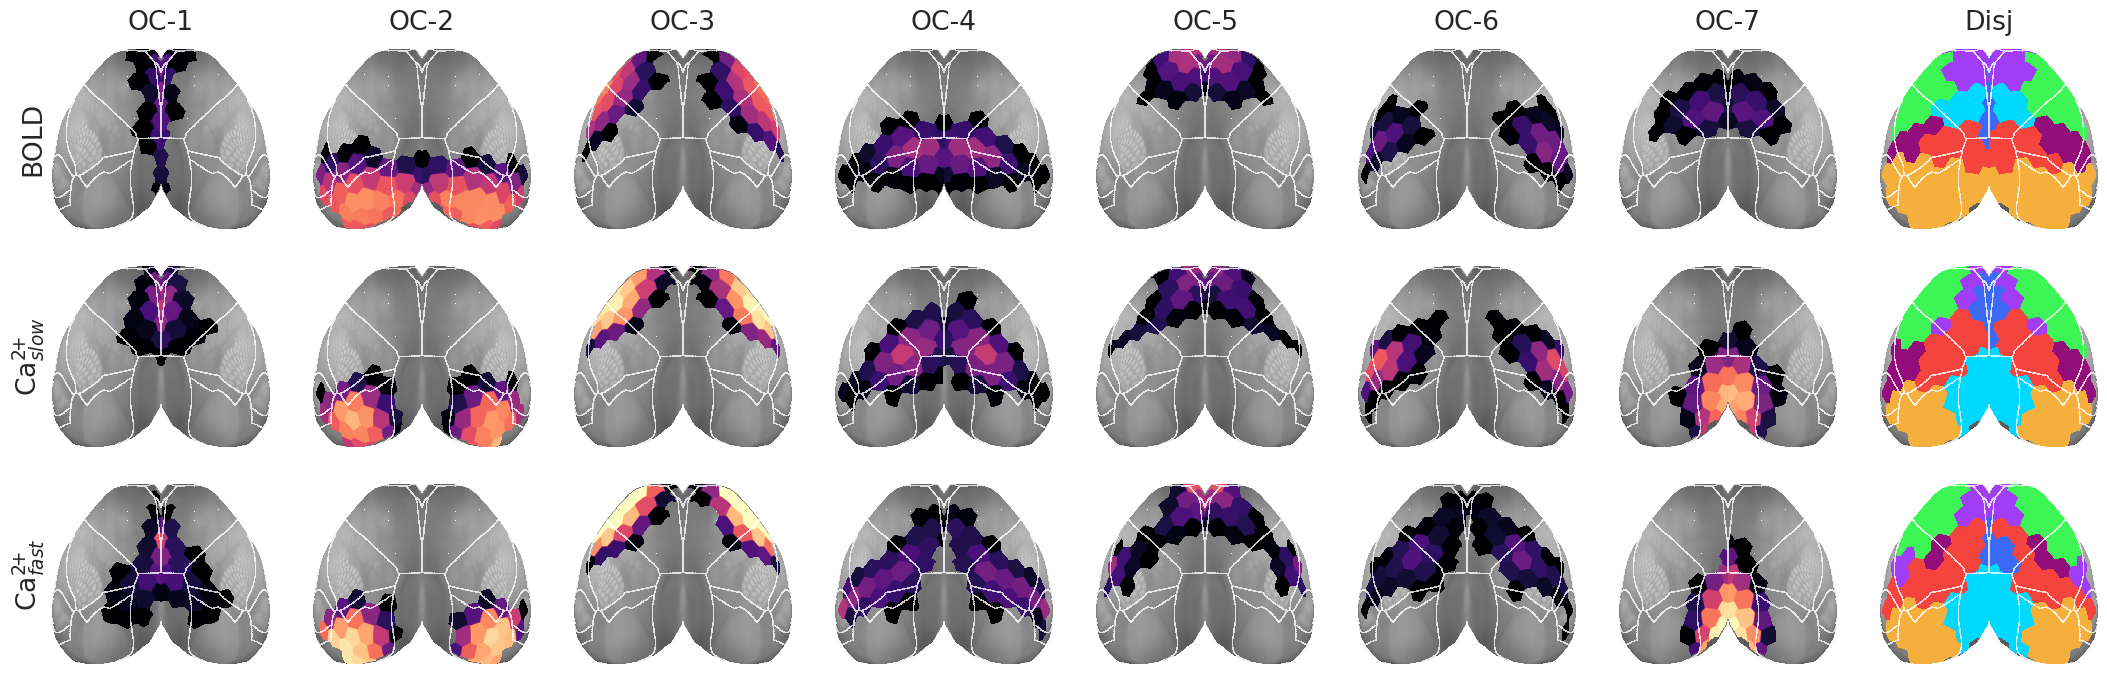

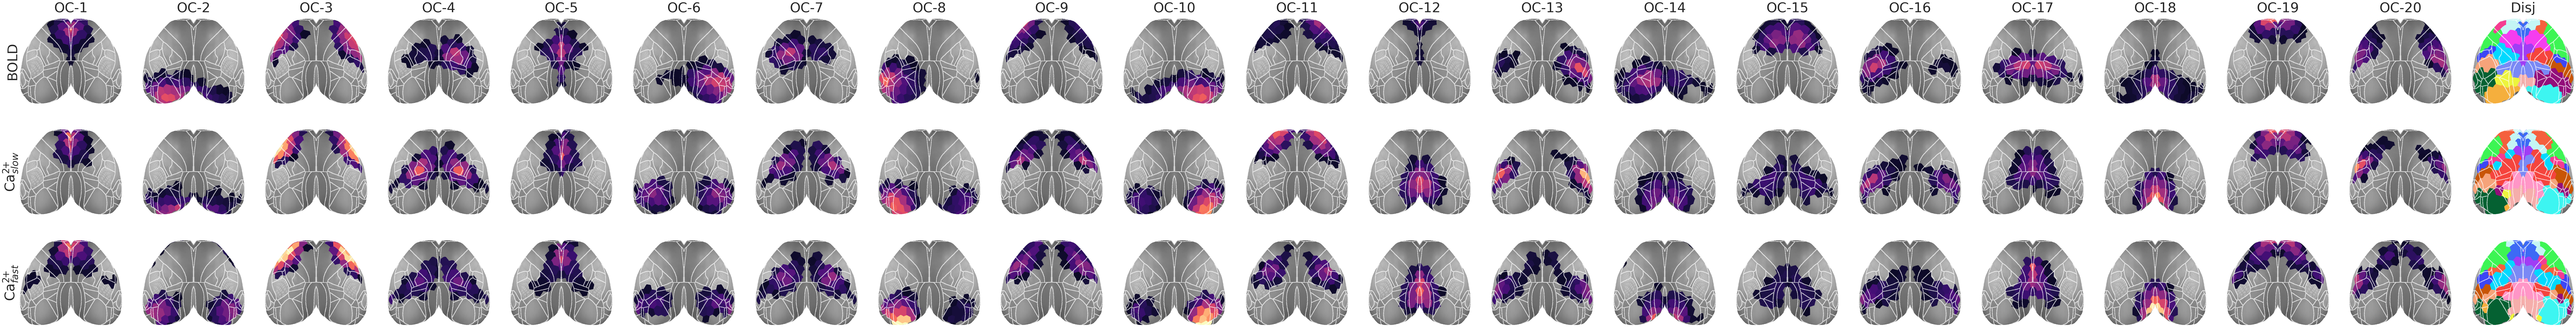

CPU times: user 18min 21s, sys: 47 s, total: 19min 8s
Wall time: 19min 28s


In [5]:
%%time

results = {}
for num_k in [3, 7, 20]:
    res = similiarity_results(
        mice=mice,
        perc=perc,
        num_k=num_k,
        n_resamples=int(1e4),
        merge_thres=0.376 if
        num_k == 7 else None,
        final_perm=final_perm if
        num_k == 7 else None,
    )
    results[num_k] = res

    bt = BootStrap(**res['props_ca'])
    _ = bt.show(res['pi_sorted'], **show_kws(num_k))

## Overall sim

### Point plot

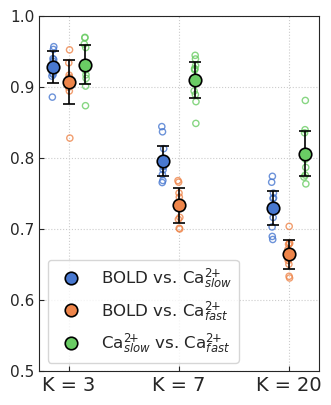

In [6]:
from figures.fig_ocs import similarity_point as go
fig, _ = go(results, True)

fig.savefig(pjoin(fig_dir, 'sim_pt.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'sim_pt.png'), **kws_fig)

## FDR correction

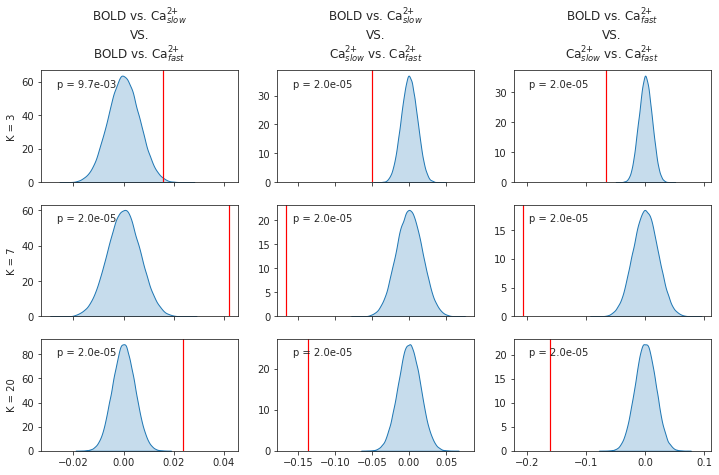

In [7]:
fig, axes = create_figure(3, 3, (12, 7), 'col')

for i, (num_k, res) in enumerate(results.items()):
    for j, (k, test) in enumerate(res['tests_overall'].items()):
        ax = axes[i, j]
        sns.kdeplot(
            x=test.null_distribution,
            shade=True,
            ax=ax,
        )
        ax.axvline(test.statistic, color='r', ls='-', lw=1.2)
        ax.annotate(
            text=f"p = {test.pvalue:1.1e}",
            xycoords='axes fraction',
            xy=(0.08, 0.85),
        )
        if i == 0:
            ax.set_title(f"{k[0][0]} vs. {k[0][1]}\nVS.\n{k[1][0]} vs. {k[1][1]}", y=1.05)
        if j == 0:
            ax.set_ylabel(f'K = {num_k}')
        else:
            ax.set_ylabel('')
plt.show()

### Significance levels

In [8]:
pvals = {}
for num_k, res in results.items():
    for k, test in res['tests_overall'].items():
        pvals[(num_k, ) + k] = test.pvalue

In [9]:
for alpha in [0.001, 0.01, 0.05]:
    reject, *_ = multipletests(
        pvals=list(pvals.values()),
        method='fdr_bh',
        alpha=alpha,
    )
    print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.001;  reject:
[False  True  True  True  True  True  True  True  True]

alpha = 0.01;  reject:
[ True  True  True  True  True  True  True  True  True]

alpha = 0.05;  reject:
[ True  True  True  True  True  True  True  True  True]

## Bonferroni correction

### Significance levels

In [10]:
pvals = {}
for num_k, res in results.items():
    for k, test in res['tests_overall'].items():
        pvals[(num_k, ) + k] = test.pvalue

In [11]:
for alpha in [0.001, 0.01, 0.05]:
    reject, *_ = multipletests(
        pvals=list(pvals.values()),
        method='bonferroni',
        alpha=alpha,
    )
    print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.001;  reject:
[False  True  True  True  True  True  True  True  True]

alpha = 0.01;  reject:
[False  True  True  True  True  True  True  True  True]

alpha = 0.05;  reject:
[False  True  True  True  True  True  True  True  True]

In [12]:
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    pvals=list(pvals.values()),
    method='bonferroni',
    alpha=0.05,
)
print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.05;  reject:
[False  True  True  True  True  True  True  True  True]

In [13]:
np.round(pvals_corrected, 3)

array([0.088, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [14]:
alphacBonf, 0.05 / 9

(0.005555555555555556, 0.005555555555555556)

In [15]:
cond = ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
pvals3 = {(kk, *cond): pvals[(kk, *cond)] for kk in [3, 7, 20]}

In [16]:
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    pvals=list(pvals3.values()),
    method='bonferroni',
    alpha=0.05,
)
print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.05;  reject:
[ True  True  True]

In [17]:
pvals_corrected

array([2.92197078e-02, 5.99994000e-05, 5.99994000e-05])

## Fig dir (p=15)

In [18]:
nn = 128
perc = 15
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n128-p15/Fig2_OCs

## Prepare (128)

In [19]:
mice = Mice(nn)
num_k = None

## Get results

In [20]:
final_perm={1: 4, 4: 6, 6: 1}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(7)
}
final_perm

{0: 0, 1: 4, 2: 2, 3: 3, 4: 6, 5: 5, 6: 1}

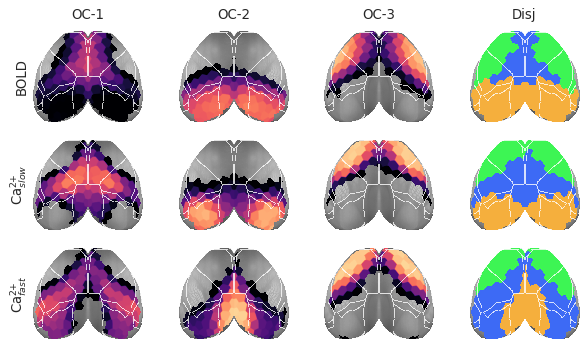

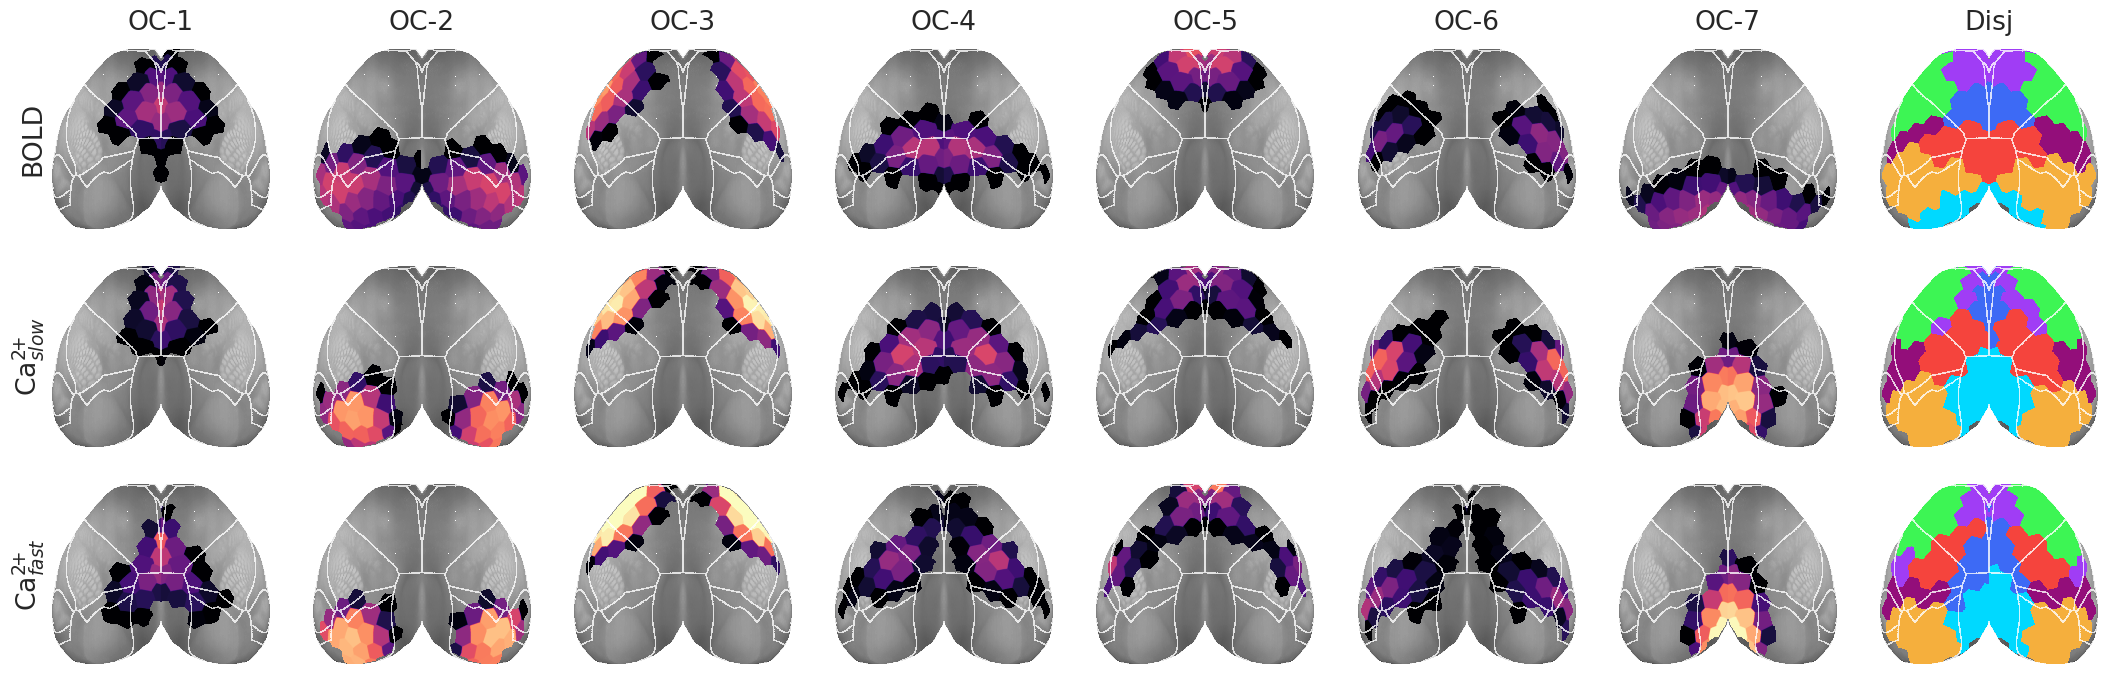

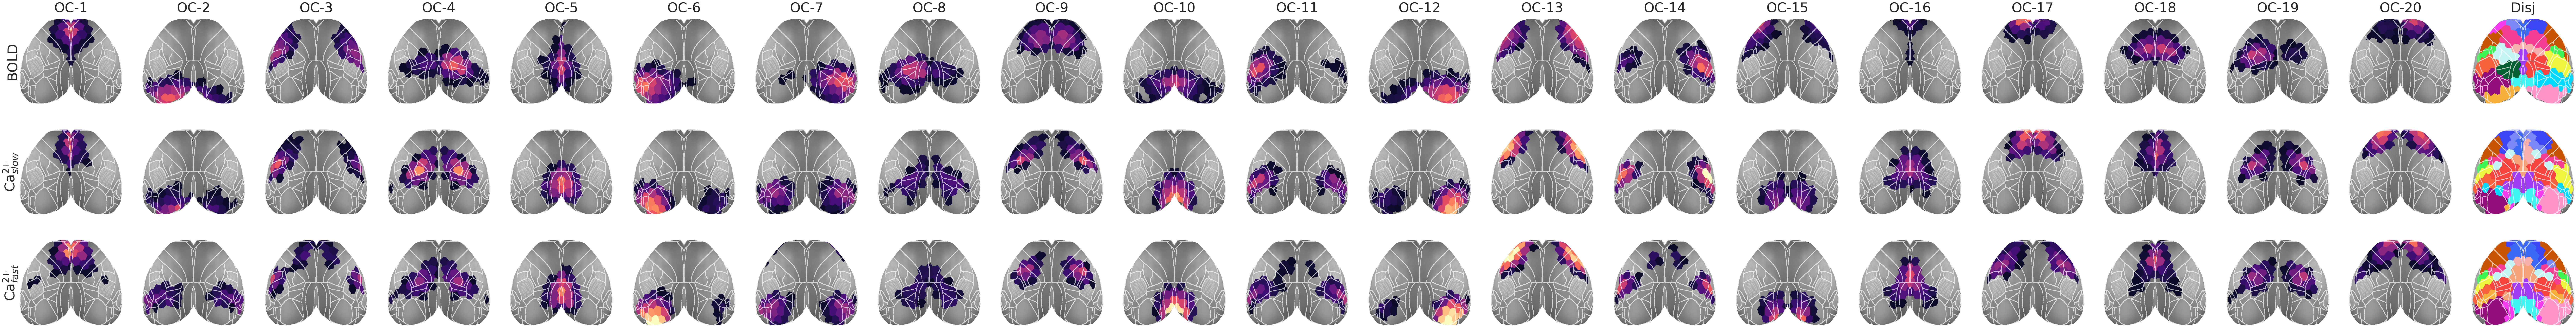

CPU times: user 18min 39s, sys: 28.4 s, total: 19min 8s
Wall time: 19min 49s


In [21]:
%%time

results = {}
for num_k in [3, 7, 20]:
    res = similiarity_results(
        mice=mice,
        perc=perc,
        num_k=num_k,
        n_resamples=int(1e4),
        merge_thres=0.376 if
        num_k == 7 else None,
        final_perm=final_perm if
        num_k == 7 else None,
    )
    results[num_k] = res

    bt = BootStrap(**res['props_ca'])
    _ = bt.show(res['pi_sorted'], **show_kws(num_k))

## Overall sim

### Point plot

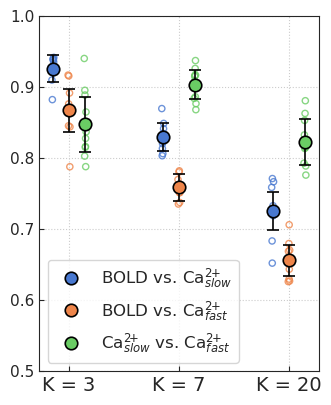

In [22]:
from figures.fig_ocs import similarity_point as go
fig, _ = go(results, True)

fig.savefig(pjoin(fig_dir, 'sim_pt.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'sim_pt.png'), **kws_fig)

## FDR correction

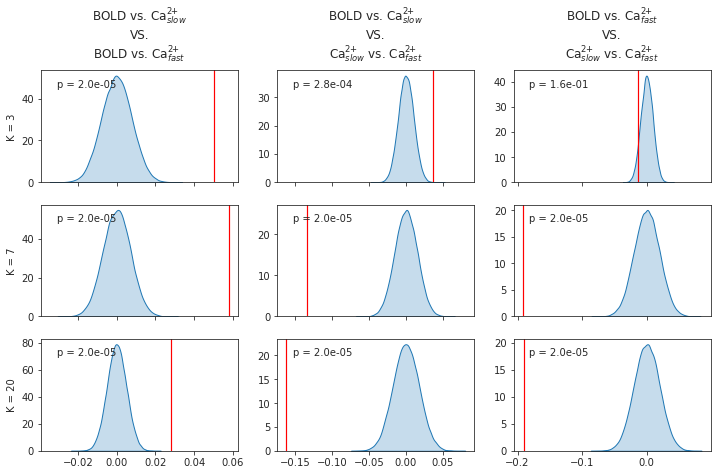

In [23]:
fig, axes = create_figure(3, 3, (12, 7), 'col')

for i, (num_k, res) in enumerate(results.items()):
    for j, (k, test) in enumerate(res['tests_overall'].items()):
        ax = axes[i, j]
        sns.kdeplot(
            x=test.null_distribution,
            shade=True,
            ax=ax,
        )
        ax.axvline(test.statistic, color='r', ls='-', lw=1.2)
        ax.annotate(
            text=f"p = {test.pvalue:1.1e}",
            xycoords='axes fraction',
            xy=(0.08, 0.85),
        )
        if i == 0:
            ax.set_title(f"{k[0][0]} vs. {k[0][1]}\nVS.\n{k[1][0]} vs. {k[1][1]}", y=1.05)
        if j == 0:
            ax.set_ylabel(f'K = {num_k}')
        else:
            ax.set_ylabel('')
plt.show()

### Significance levels

In [24]:
pvals = {}
for num_k, res in results.items():
    for k, test in res['tests_overall'].items():
        pvals[(num_k, ) + k] = test.pvalue

In [25]:
for alpha in [0.001, 0.01, 0.05]:
    reject, *_ = multipletests(
        pvals=list(pvals.values()),
        method='fdr_bh',
        alpha=alpha,
    )
    print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.001;  reject:
[ True  True False  True  True  True  True  True  True]

alpha = 0.01;  reject:
[ True  True False  True  True  True  True  True  True]

alpha = 0.05;  reject:
[ True  True False  True  True  True  True  True  True]

## Bonferroni correction

### Significance levels

In [26]:
pvals = {}
for num_k, res in results.items():
    for k, test in res['tests_overall'].items():
        pvals[(num_k, ) + k] = test.pvalue

In [27]:
for alpha in [0.001, 0.01, 0.05]:
    reject, *_ = multipletests(
        pvals=list(pvals.values()),
        method='bonferroni',
        alpha=alpha,
    )
    print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.001;  reject:
[ True False False  True  True  True  True  True  True]

alpha = 0.01;  reject:
[ True  True False  True  True  True  True  True  True]

alpha = 0.05;  reject:
[ True  True False  True  True  True  True  True  True]

In [28]:
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    pvals=list(pvals.values()),
    method='bonferroni',
    alpha=0.05,
)
print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.05;  reject:
[ True  True False  True  True  True  True  True  True]

In [29]:
np.round(pvals_corrected, 3)

array([0.   , 0.003, 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [30]:
alphacBonf, 0.05 / 9

(0.005555555555555556, 0.005555555555555556)

In [31]:
cond = ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
pvals3 = {(kk, *cond): pvals[(kk, *cond)] for kk in [3, 7, 20]}

In [32]:
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    pvals=list(pvals3.values()),
    method='bonferroni',
    alpha=0.05,
)
print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.05;  reject:
[ True  True  True]

In [33]:
pvals_corrected

array([5.99994e-05, 5.99994e-05, 5.99994e-05])